In [35]:
# 1.目的
# 着番の予想精度を上げるため、通過順位を説明変数に用いたい
# 通過順位は出走前はわからないため、予想する必要がある
# 予想脚質、馬番、直近タイム指数を説明変数に用い、ゴール直近の通貨順位に対して有用なのか調べたい
# また、ついでに予想脚質がどのくらい正確に予想できているのかも知りたい
# （正確なのであれば、例えば予想脚質が"逃げ"ならゴール直前の通貨順位は小さいはず）
# 2.やったこと
# XGBoostを使う。目的変数を通過順位として各説明変数を使って高い精度を出せるか調べる
# ただし、学習データは同レースにおける馬の脚質予想の割合でフィルタリングしてから分析に用いる
# なぜならば、脚質予想の割合が異なるレースが混じっている状態で正しく分析できないからである
# 例えば通過順位が3位であるとしても、以下の2パターンが考えられる
# ・予想脚質が追込である馬が8頭中6頭いて、追込の馬が後方集団にいながら通過順位が3位である
# ・予想脚質が逃げである馬が8頭中3頭いて、逃げの馬が前方集団にいながら通過順位が3位である
# 3.結果に対する所感
# 予想脚質、馬番、直近タイム指数は通過順位に有意であると考えられる
# 特に逃げ・先行の頭数と差し・追込の頭数の差が小さいほど有意である
# ただし逃げ・先行の頭数が差し・追込みの頭数を上回る場合においては一部有意ではない結果が得られる

In [2]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [4]:
# CSVファイルの読み込み
df = pd.read_csv('input_編集後.csv', encoding='utf-8')
print(f"dfの行数は {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
# フィルタ条件を適用
filtered_df = df[
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])
# レースごとの馬のタイム指数の平均値を計算し、タイム指数との差を計算する
race_avg_time_index = filtered_df.groupby('race_id')['time_index_average_1'].transform('mean')
# 平均との差を新しいカラムとして追加
filtered_df['time_index_diff_from_avg'] = filtered_df['time_index_average_1'] - race_avg_time_index
# 結果を確認
print(filtered_df[[
    'race_id',
    'horse_number',
    'time_index_average_1',
    'jockey_place_rate_9',
    'conditional_place_rate_10'
]].head(40))

dfの行数は 51816 
filtered_dfの行数は 22088 
         race_id  horse_number  time_index_average_1  jockey_place_rate_9  \
29728  230101C01             1                   NaN                 0.20   
29729  230101C01             2                 -24.5                 0.08   
29730  230101C01             3                   NaN                 0.52   
29731  230101C01             4                  -5.0                 0.36   
29732  230101C01             5                   7.0                 0.40   
29733  230101C01             6                 -37.5                 0.36   
29734  230101C01             7                  -9.0                 0.42   
29735  230101C01             8                   0.0                 0.14   
29736  230101C09             1                  45.5                 0.56   
29737  230101C09             2                  12.5                 0.16   
29738  230101C09             3                  18.5                 0.40   
29739  230101C09             4         

In [6]:
# レースIDの先頭2桁を抽出（文字列として扱う）
filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
# 件数カウント
count_23 = (filtered_df['race_id_year'] == '23').sum()
count_24 = (filtered_df['race_id_year'] == '24').sum()
# 割合を計算
rate_24 = count_24 / (count_23 + count_24)
# 結果表示
print(f"24の割合: {rate_24:.2f}")
# 説明変数
x = filtered_df[[
    'time_index_diff_from_avg',
    'jockey_place_rate_9',
    'conditional_place_rate_10'
]]
# 目的変数
y = filtered_df["finish_rank"]
# 学習データと検証データの分割（検証データ割合はrate_24）
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=rate_24, shuffle=False)
# モデルの学習
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# y*_predの評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
# y*_rankの評価
# 予測結果を DataFrame に変換して race_id と紐付け
y_pred_df = pd.DataFrame({
    'race_id': filtered_df.loc[x_test.index, 'race_id'].values,
    'y_pred': y_pred
})
# 各レースごとに予測値の小さい順に順位を振る（昇順）
y_pred_df['y_rank'] = y_pred_df.groupby('race_id')['y_pred'].rank(method='first').astype(int)
# 3. 実着順を追加
y_pred_df['y_actual'] = y_test.values
# 正解率（的中率）の計算と出力
correct_top1_count = ((y_pred_df['y_rank'] == 1) & (y_pred_df['y_actual'] == 1)).sum()
unique_race_count = y_pred_df['race_id'].nunique()
top1_accuracy = correct_top1_count / unique_race_count
print(f"1着予測的中率: {top1_accuracy:.4f} （{correct_top1_count} / {unique_race_count}）")
# 実データを出力して確認
y_pred_df.sort_values(by=['race_id', 'y_actual'], ascending=[True, True]).head(56)

24の割合: 0.48
RMSE: 1.9560
R2 Score: 0.2711
1着予測的中率: 0.3732 （533 / 1428）


,race_id,y_pred,y_rank,y_actual
4,231205D02,5.673598,6,1
1,231205D02,4.177815,4,2
2,231205D02,4.090909,3,3
3,231205D02,3.475122,1,4
5,231205D02,6.115883,8,5
0,231205D02,4.059711,2,6
6,231205D02,4.745653,5,7
7,231205D02,5.743482,7,8
9,231205D07,3.211758,2,1
11,231205D07,2.417650,1,2


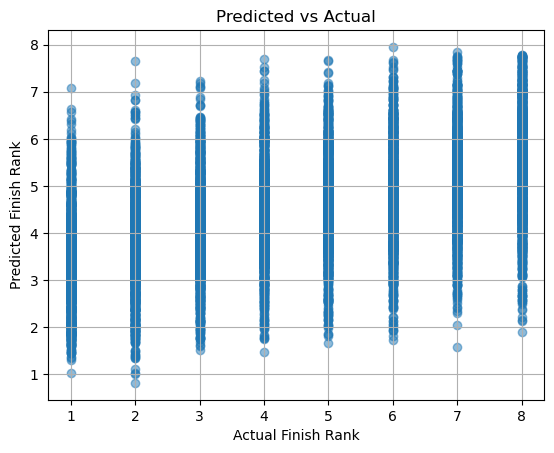

各特徴量の重要度（大きいほど重要）:
                     Feature  Importance
0   time_index_diff_from_avg    0.629613
2  conditional_place_rate_10    0.214937
1        jockey_place_rate_9    0.155450


C:\Users\ryo\AppData\Local\Temp\ipykernel_1684\3136151629.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


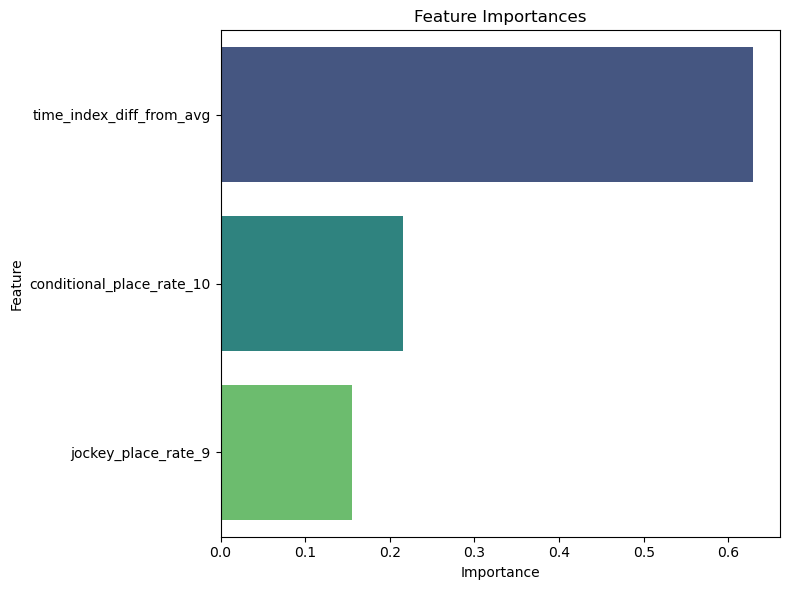

In [8]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
# 予想と正解のプロット
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Finish Rank")
plt.ylabel("Predicted Finish Rank")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()
# 特徴量の重要度
importances = model.feature_importances_
feature_names = x.columns
# DataFrameにしてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("各特徴量の重要度（大きいほど重要）:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
